# TP Coding a GAN in Pytorch

Author : Alasdair Newson

alasdair.newson@telecom-paris.fr

## Objective:

The goal of this TP is to explore GANs applied to the mnist (and possibly cifar10) datasets.

We will start with the mnist dataset.

### Your task:
You need to add the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE or # FILL IN CODE)

First of all, let's load some packages

In [1]:

import matplotlib.pyplot as plt
import sys
import numpy as np
import pickle
import copy
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

def pytorch_to_numpy(x):
  return x.detach().numpy()


# Decide which device we want to run on
if (torch.cuda.is_available()):
  device = torch.device("cuda:0")
else:
  device = "cpu"


## 1/ Loading the data

We define a function to load the mnist or cifar10 datasets. Note, we normalise the data between -1 and 1 here (this is often the case for GANs).

In [2]:

# create a random seed for reproducible results
random_seed = 1
torch.manual_seed(random_seed)

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

# MNIST Dataset
mnist_trainset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
mnist_testset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

#create data loader with smaller dataset size
max_mnist_size = 1000
mnist_trainset_reduced = torch.utils.data.random_split(mnist_trainset, [max_mnist_size, len(mnist_trainset)-max_mnist_size])[0] 
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset_reduced, batch_size=64, shuffle=True)

# download test dataset
max_mnist_size = 512
mnist_testset_reduced = torch.utils.data.random_split(mnist_testset, [max_mnist_size, len(mnist_testset)-max_mnist_size])[0] 
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset_reduced, batch_size=64, shuffle=True)



In [3]:
n_rows = mnist_trainset_reduced.dataset.train_data.shape[1]
n_cols = mnist_trainset_reduced.dataset.train_data.shape[2]
n_channels = 1
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)

/home/luizf/miniconda3/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


## 2/ GAN parameters

In [4]:

## GAN parameters
z_dim = 10
batch_size = 64
## parameters for training
n_epochs = 400
n_iters_inner=1	#number of internal loops
sample_interval=100
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5

# hidden dimensions : careful, the order here is with respect to the generator, and the discriminator is in the opposite order
h_dim_1 = 256
h_dim_2 = 512

## 3/ Model architecture

Now, we define the model architecture.

For the first dataset, mnist, we are going to use fully connected layers. Implement the following architecture, for the generator and the discriminator :

Generator :
- Dense layer, to size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 784
- Tanh activation
- Reshape to size $28 \times 28 \times 1$

Discriminator :
- Flatten
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 1
- Sigmoid activation

In [5]:
# Generator Code

class Generator(nn.Module):
  def __init__(self, z_dim, h_dim_1, h_dim_2, n_rows,n_cols,n_channels):
    super(Generator, self).__init__()
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim

    self.fc1 = nn.Linear(self.z_dim, self.h_dim_1)
    self.fc2 = nn.Linear(self.h_dim_1, self.h_dim_2)
    self.fc3 = nn.Linear(self.h_dim_2, self.n_pixels)
  def forward(self, z):
    y = F.leaky_relu(self.fc1(z),0.2)
    y = F.leaky_relu(self.fc2(y),0.2)
    y = torch.tanh(self.fc3(y))
    y = y.view(y.shape[0], self.n_channels, self.n_rows, self.n_cols)

    return(y)


In [6]:

class Discriminator(nn.Module):
  def __init__(self, h_dim_2, h_dim_1, z_dim, n_rows,n_cols,n_channels):
    super(Discriminator, self).__init__()

    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim

    self.fc1 = nn.Linear( self.n_pixels, h_dim_2)
    self.fc2 = nn.Linear(h_dim_2, h_dim_1)
    self.fc3 = nn.Linear(h_dim_1, 1)

  def forward(self, x):
    y = x.flatten(start_dim=1)
    y = F.leaky_relu(self.fc1(y),0.2)
    y = F.leaky_relu(self.fc2(y),0.2)
    y = torch.sigmoid(self.fc3(y))
    return y




Create generator and discriminator 

In [7]:
gen_model = Generator(z_dim, h_dim_1, h_dim_2, n_rows,n_cols,n_channels)
# Print the model
print(gen_model)

disc_model = Discriminator(h_dim_2, h_dim_1, z_dim, n_rows,n_cols,n_channels)
# Print the model
print(disc_model)

Generator(
  (fc1): Linear(in_features=10, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=784, bias=True)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


## 4/ Loss function


The GAN loss function is the following :
\begin{equation}
	\min_{G} \max_{D} \mathbb{E}_{x \in p_{data}} \left[ \log D(x)\right] +
	\mathbb{E}_{z \in p_{z}}\left[ \log \left( 1 - D(G(z)) \right)\right],
\end{equation}
where $G$ is the generator, $D$ is the discriminator, $z$ is the latent code, which follows a normal distribution.

You should notice that this is extremely similar to the binary cross-entropy function. Therefore, there is an intelligent way to train the discriminator : we give it first a batch of real images, and label them as real, and secondly we give a batch of fake images and label them as fake. Therefore, the discriminator training itself is done in two sequential steps (first true, then fake). If the labels are correctly chosen (further on, during training), you can (and __should__) use the binary cross-entropy function.

The generator loss, however, must be specified as :
- $mean(\log(1-D(G(z))))$

You can use the ```torch.mean``` function for this purpose.


The training is carried out sequentially : first we execute a few training steps on the discriminator, and then one on the generator. Therefore, we use two loops : one to train the discriminator (the internal loop) and one to train the generator (external loop, ie. the number of epochs). The GAN training algorithm is as follows :

- For $i=0$ to $n-1$
  - For $j=0$ to $m-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$



In [8]:

# Setup Adam optimizers for both G and D
optimizer_disc = optim.Adam(disc_model.parameters(), lr=lr, betas=(beta_1, 0.999))
optimizer_gen = optim.Adam(gen_model.parameters(), lr=lr, betas=(beta_1, 0.999))

# criterion used for the discriminator loss
bce_criterion = nn.BCELoss()

# criterion used for the generator loss
def loss_fn_gen(d_gen_data):
  loss_gen = -torch.mean(torch.log(d_gen_data))
  return loss_gen

	

### Sampling function

We now create a function to sample several images during training (to follow the convergence of the network)

In [9]:

def sample_images(generator,z_dim, rand_seed=30):
  #np.random.seed(rand_seed)
  r, c = 5, 5
  z_random = torch.randn(r * c, 1, z_dim, dtype=torch.float, device=device) #np.random.normal(0, 1, (r * c, z_dim))
  
  gen_imgs = np.transpose( generator(z_random).cpu().detach().numpy() , (0,2,3,1))

  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      #black and white images
      if(gen_imgs.shape[3] == 1):
        axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
      elif(gen_imgs.shape[3] == 3):   #colour images
        gen_imgs_temp = gen_imgs.copy()
        gen_imgs_temp = 255.*np.clip(gen_imgs_temp,0.0,1.0) 
        axs[i,j].imshow(gen_imgs_temp[cnt, :,:,:].astype(np.uint8))
      else:
        print('Error, unsupported channel size. Dude, I don''t know what you want me to do.\
            I can''t handle this data. You''ve made me very sad ...')
      axs[i,j].axis('off')
      cnt += 1
  plt.show()

## 5/ Training

We are now ready to train the network. Here is the training algorithm again :

- For $i=0$ to $n-1$
  - For $j=0$ to $m-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$

You can use ```np.random.normal``` to create a batch of random latent codes, and ```np.random.randint``` to create a batch of random images.

You can then train the discriminator and the generator using the ```train_on_batch``` function.

We do not worry here about looping over the whole database : just create a random batch at each iteration.

Starting Training
[0/400][0/16] 	Loss_D: 1.4496	Loss_G: 0.7194	D(x): 0.4578	D(G(z)): 0.4873


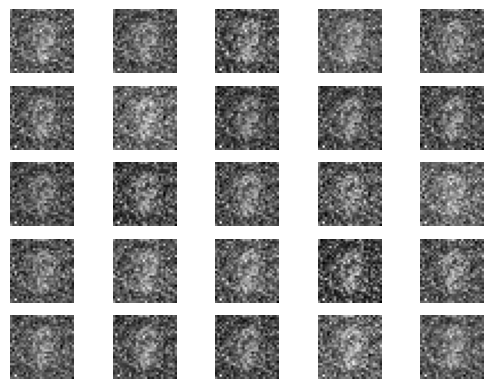

[1/400][0/16] 	Loss_D: 0.9850	Loss_G: 0.6301	D(x): 0.8715	D(G(z)): 0.5710
[2/400][0/16] 	Loss_D: 1.1878	Loss_G: 0.6293	D(x): 0.7775	D(G(z)): 0.6066
[3/400][0/16] 	Loss_D: 1.2235	Loss_G: 0.7697	D(x): 0.6781	D(G(z)): 0.5643
[4/400][0/16] 	Loss_D: 1.2170	Loss_G: 0.7809	D(x): 0.6403	D(G(z)): 0.5347
[5/400][0/16] 	Loss_D: 1.1713	Loss_G: 1.0651	D(x): 0.6695	D(G(z)): 0.5313
[6/400][0/16] 	Loss_D: 1.1009	Loss_G: 1.2762	D(x): 0.6939	D(G(z)): 0.5161
[7/400][0/16] 	Loss_D: 1.1770	Loss_G: 1.3364	D(x): 0.7101	D(G(z)): 0.5582
[8/400][0/16] 	Loss_D: 0.7469	Loss_G: 1.8266	D(x): 0.8151	D(G(z)): 0.4152
[9/400][0/16] 	Loss_D: 0.8472	Loss_G: 1.2169	D(x): 0.7574	D(G(z)): 0.4306
[10/400][0/16] 	Loss_D: 1.2903	Loss_G: 1.2141	D(x): 0.7792	D(G(z)): 0.6426
[11/400][0/16] 	Loss_D: 1.3947	Loss_G: 0.6979	D(x): 0.6148	D(G(z)): 0.5924
[12/400][0/16] 	Loss_D: 1.3293	Loss_G: 0.7074	D(x): 0.5653	D(G(z)): 0.5254
[13/400][0/16] 	Loss_D: 1.2625	Loss_G: 1.1233	D(x): 0.7291	D(G(z)): 0.6079
[14/400][0/16] 	Loss_D: 1.0690	Los

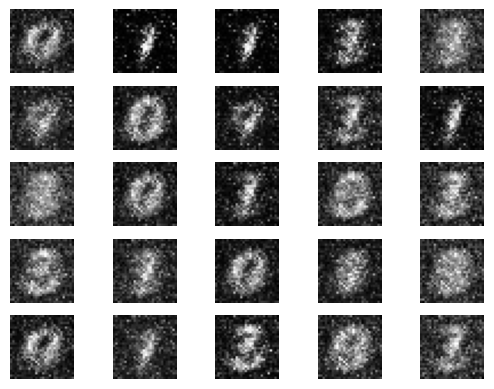

[26/400][0/16] 	Loss_D: 1.0679	Loss_G: 1.1639	D(x): 0.6702	D(G(z)): 0.4676
[27/400][0/16] 	Loss_D: 1.0110	Loss_G: 0.9994	D(x): 0.5916	D(G(z)): 0.3634
[28/400][0/16] 	Loss_D: 1.1326	Loss_G: 1.4616	D(x): 0.7270	D(G(z)): 0.5384
[29/400][0/16] 	Loss_D: 0.8571	Loss_G: 1.6058	D(x): 0.7573	D(G(z)): 0.4271
[30/400][0/16] 	Loss_D: 1.1269	Loss_G: 0.6123	D(x): 0.4502	D(G(z)): 0.2139
[31/400][0/16] 	Loss_D: 0.9107	Loss_G: 0.8842	D(x): 0.5885	D(G(z)): 0.2823
[32/400][0/16] 	Loss_D: 0.6815	Loss_G: 1.2673	D(x): 0.7763	D(G(z)): 0.3287
[33/400][0/16] 	Loss_D: 0.7775	Loss_G: 1.1630	D(x): 0.6538	D(G(z)): 0.2472
[34/400][0/16] 	Loss_D: 0.8047	Loss_G: 1.6471	D(x): 0.7395	D(G(z)): 0.3709
[35/400][0/16] 	Loss_D: 0.9969	Loss_G: 1.2079	D(x): 0.5232	D(G(z)): 0.2312
[36/400][0/16] 	Loss_D: 1.1275	Loss_G: 0.7488	D(x): 0.4606	D(G(z)): 0.1647
[37/400][0/16] 	Loss_D: 0.8619	Loss_G: 1.9883	D(x): 0.8345	D(G(z)): 0.4773
[38/400][0/16] 	Loss_D: 1.1265	Loss_G: 0.9246	D(x): 0.5119	D(G(z)): 0.2707
[39/400][0/16] 	Loss_D: 0

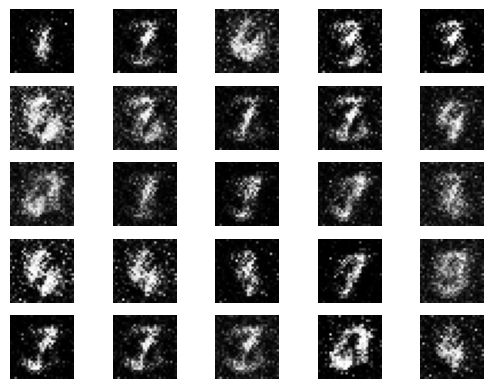

[51/400][0/16] 	Loss_D: 0.9232	Loss_G: 1.8094	D(x): 0.7593	D(G(z)): 0.4428
[52/400][0/16] 	Loss_D: 1.0707	Loss_G: 2.0622	D(x): 0.8815	D(G(z)): 0.5913
[53/400][0/16] 	Loss_D: 0.8607	Loss_G: 1.8003	D(x): 0.8500	D(G(z)): 0.4854
[54/400][0/16] 	Loss_D: 0.7957	Loss_G: 1.3176	D(x): 0.6830	D(G(z)): 0.3018
[55/400][0/16] 	Loss_D: 0.7506	Loss_G: 2.0097	D(x): 0.8119	D(G(z)): 0.3946
[56/400][0/16] 	Loss_D: 0.9823	Loss_G: 2.9177	D(x): 0.8746	D(G(z)): 0.5548
[57/400][0/16] 	Loss_D: 0.6316	Loss_G: 1.5833	D(x): 0.7879	D(G(z)): 0.3058
[58/400][0/16] 	Loss_D: 0.5583	Loss_G: 1.9103	D(x): 0.7553	D(G(z)): 0.2178
[59/400][0/16] 	Loss_D: 0.6819	Loss_G: 1.3401	D(x): 0.6774	D(G(z)): 0.2065
[60/400][0/16] 	Loss_D: 1.3737	Loss_G: 1.2900	D(x): 0.3627	D(G(z)): 0.0443
[61/400][0/16] 	Loss_D: 0.7066	Loss_G: 2.1978	D(x): 0.7918	D(G(z)): 0.3417
[62/400][0/16] 	Loss_D: 0.7717	Loss_G: 1.9892	D(x): 0.5742	D(G(z)): 0.0940
[63/400][0/16] 	Loss_D: 0.5344	Loss_G: 1.7414	D(x): 0.7760	D(G(z)): 0.2155
[64/400][0/16] 	Loss_D: 0

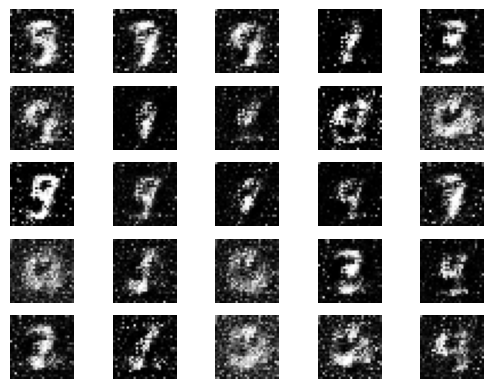

[76/400][0/16] 	Loss_D: 0.7641	Loss_G: 2.4990	D(x): 0.8839	D(G(z)): 0.4527
[77/400][0/16] 	Loss_D: 0.5135	Loss_G: 2.2792	D(x): 0.8218	D(G(z)): 0.2528
[78/400][0/16] 	Loss_D: 0.8989	Loss_G: 2.4686	D(x): 0.8434	D(G(z)): 0.4881
[79/400][0/16] 	Loss_D: 0.6743	Loss_G: 1.3716	D(x): 0.7005	D(G(z)): 0.2181
[80/400][0/16] 	Loss_D: 1.1196	Loss_G: 3.5440	D(x): 0.9218	D(G(z)): 0.6195
[81/400][0/16] 	Loss_D: 0.6598	Loss_G: 3.0878	D(x): 0.8867	D(G(z)): 0.3968
[82/400][0/16] 	Loss_D: 0.6425	Loss_G: 1.7987	D(x): 0.6867	D(G(z)): 0.1494
[83/400][0/16] 	Loss_D: 0.6415	Loss_G: 1.4941	D(x): 0.6846	D(G(z)): 0.1551
[84/400][0/16] 	Loss_D: 0.7831	Loss_G: 3.1495	D(x): 0.8684	D(G(z)): 0.4514
[85/400][0/16] 	Loss_D: 0.9178	Loss_G: 1.8990	D(x): 0.5286	D(G(z)): 0.0770
[86/400][0/16] 	Loss_D: 1.3010	Loss_G: 0.6508	D(x): 0.4094	D(G(z)): 0.0612
[87/400][0/16] 	Loss_D: 0.5414	Loss_G: 2.0216	D(x): 0.8604	D(G(z)): 0.2979
[88/400][0/16] 	Loss_D: 0.5872	Loss_G: 1.8072	D(x): 0.7412	D(G(z)): 0.1982
[89/400][0/16] 	Loss_D: 0

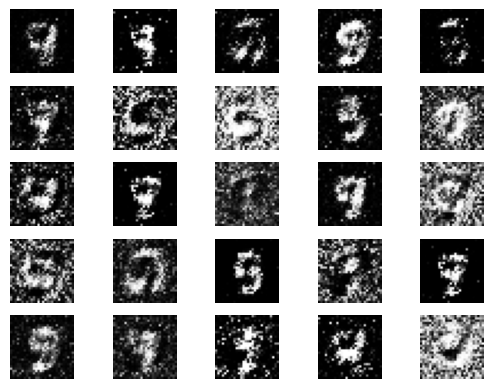

[101/400][0/16] 	Loss_D: 1.2094	Loss_G: 3.4924	D(x): 0.9849	D(G(z)): 0.6149
[102/400][0/16] 	Loss_D: 0.6726	Loss_G: 2.7230	D(x): 0.8741	D(G(z)): 0.3531
[103/400][0/16] 	Loss_D: 0.6310	Loss_G: 2.9125	D(x): 0.8561	D(G(z)): 0.3502
[104/400][0/16] 	Loss_D: 0.7102	Loss_G: 1.5933	D(x): 0.7115	D(G(z)): 0.2255
[105/400][0/16] 	Loss_D: 0.8621	Loss_G: 3.3431	D(x): 0.8717	D(G(z)): 0.4684
[106/400][0/16] 	Loss_D: 0.7907	Loss_G: 1.3417	D(x): 0.6750	D(G(z)): 0.2542
[107/400][0/16] 	Loss_D: 0.5670	Loss_G: 1.5093	D(x): 0.7277	D(G(z)): 0.1666
[108/400][0/16] 	Loss_D: 0.6896	Loss_G: 1.8778	D(x): 0.8196	D(G(z)): 0.3350
[109/400][0/16] 	Loss_D: 0.7502	Loss_G: 3.1426	D(x): 0.9089	D(G(z)): 0.4521
[110/400][0/16] 	Loss_D: 0.8456	Loss_G: 3.9841	D(x): 0.8864	D(G(z)): 0.4833
[111/400][0/16] 	Loss_D: 0.6303	Loss_G: 1.9268	D(x): 0.7007	D(G(z)): 0.1733
[112/400][0/16] 	Loss_D: 0.4963	Loss_G: 2.1691	D(x): 0.7990	D(G(z)): 0.2053
[113/400][0/16] 	Loss_D: 0.8827	Loss_G: 4.0645	D(x): 0.9447	D(G(z)): 0.5380
[114/400][0/

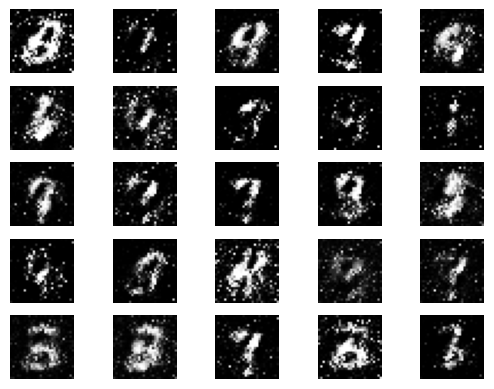

[126/400][0/16] 	Loss_D: 0.6422	Loss_G: 1.2727	D(x): 0.6779	D(G(z)): 0.1490
[127/400][0/16] 	Loss_D: 0.7542	Loss_G: 3.5060	D(x): 0.9051	D(G(z)): 0.4463
[128/400][0/16] 	Loss_D: 0.9274	Loss_G: 0.9054	D(x): 0.5454	D(G(z)): 0.0907
[129/400][0/16] 	Loss_D: 0.8590	Loss_G: 4.1931	D(x): 0.9171	D(G(z)): 0.4852
[130/400][0/16] 	Loss_D: 0.6886	Loss_G: 1.6589	D(x): 0.8423	D(G(z)): 0.3543
[131/400][0/16] 	Loss_D: 0.4591	Loss_G: 2.5404	D(x): 0.7779	D(G(z)): 0.1348
[132/400][0/16] 	Loss_D: 0.7013	Loss_G: 2.8867	D(x): 0.8941	D(G(z)): 0.4072
[133/400][0/16] 	Loss_D: 0.5783	Loss_G: 1.7253	D(x): 0.7954	D(G(z)): 0.2485
[134/400][0/16] 	Loss_D: 0.4574	Loss_G: 2.2766	D(x): 0.8385	D(G(z)): 0.2209
[135/400][0/16] 	Loss_D: 0.8331	Loss_G: 1.0062	D(x): 0.5716	D(G(z)): 0.0491
[136/400][0/16] 	Loss_D: 0.9971	Loss_G: 4.6351	D(x): 0.9269	D(G(z)): 0.5620
[137/400][0/16] 	Loss_D: 0.6136	Loss_G: 1.6347	D(x): 0.7111	D(G(z)): 0.1609
[138/400][0/16] 	Loss_D: 0.5503	Loss_G: 2.9826	D(x): 0.8906	D(G(z)): 0.3115
[139/400][0/

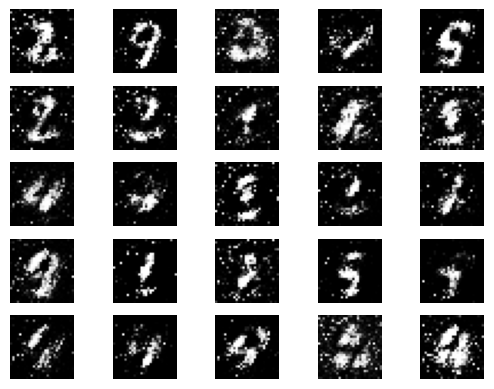

[151/400][0/16] 	Loss_D: 0.6027	Loss_G: 2.7305	D(x): 0.8545	D(G(z)): 0.3170
[152/400][0/16] 	Loss_D: 0.5868	Loss_G: 2.4320	D(x): 0.8129	D(G(z)): 0.2635
[153/400][0/16] 	Loss_D: 0.4894	Loss_G: 2.4985	D(x): 0.9019	D(G(z)): 0.2884
[154/400][0/16] 	Loss_D: 0.5256	Loss_G: 1.8002	D(x): 0.7480	D(G(z)): 0.1587
[155/400][0/16] 	Loss_D: 0.5829	Loss_G: 2.2164	D(x): 0.8077	D(G(z)): 0.2482
[156/400][0/16] 	Loss_D: 0.5821	Loss_G: 1.6833	D(x): 0.7135	D(G(z)): 0.1126
[157/400][0/16] 	Loss_D: 1.0487	Loss_G: 4.1377	D(x): 0.9499	D(G(z)): 0.5821
[158/400][0/16] 	Loss_D: 0.6372	Loss_G: 1.3788	D(x): 0.6697	D(G(z)): 0.1211
[159/400][0/16] 	Loss_D: 1.1083	Loss_G: 5.5720	D(x): 0.9536	D(G(z)): 0.6059
[160/400][0/16] 	Loss_D: 0.8676	Loss_G: 4.3206	D(x): 0.9236	D(G(z)): 0.4909
[161/400][0/16] 	Loss_D: 0.7857	Loss_G: 0.9759	D(x): 0.5949	D(G(z)): 0.0534
[162/400][0/16] 	Loss_D: 1.0813	Loss_G: 5.0375	D(x): 0.9704	D(G(z)): 0.6016
[163/400][0/16] 	Loss_D: 0.4807	Loss_G: 2.2346	D(x): 0.7670	D(G(z)): 0.1324
[164/400][0/

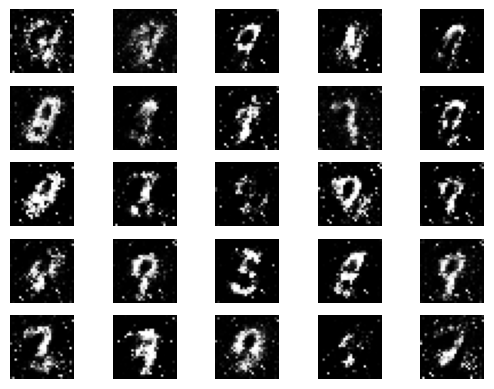

[176/400][0/16] 	Loss_D: 0.6933	Loss_G: 2.3718	D(x): 0.8081	D(G(z)): 0.3242
[177/400][0/16] 	Loss_D: 1.6690	Loss_G: 0.6553	D(x): 0.3290	D(G(z)): 0.0136
[178/400][0/16] 	Loss_D: 0.6477	Loss_G: 1.1370	D(x): 0.6638	D(G(z)): 0.0918
[179/400][0/16] 	Loss_D: 0.5699	Loss_G: 2.0270	D(x): 0.9281	D(G(z)): 0.3447
[180/400][0/16] 	Loss_D: 0.6247	Loss_G: 1.7685	D(x): 0.8456	D(G(z)): 0.3153
[181/400][0/16] 	Loss_D: 1.6313	Loss_G: 1.5365	D(x): 0.3594	D(G(z)): 0.0139
[182/400][0/16] 	Loss_D: 0.6981	Loss_G: 2.9818	D(x): 0.9296	D(G(z)): 0.4074
[183/400][0/16] 	Loss_D: 0.6628	Loss_G: 1.3655	D(x): 0.6696	D(G(z)): 0.0954
[184/400][0/16] 	Loss_D: 0.9886	Loss_G: 4.3847	D(x): 0.9514	D(G(z)): 0.5490
[185/400][0/16] 	Loss_D: 0.6177	Loss_G: 3.2343	D(x): 0.8613	D(G(z)): 0.2912
[186/400][0/16] 	Loss_D: 1.0822	Loss_G: 4.2344	D(x): 0.9534	D(G(z)): 0.5301
[187/400][0/16] 	Loss_D: 0.6390	Loss_G: 2.9999	D(x): 0.8330	D(G(z)): 0.3125
[188/400][0/16] 	Loss_D: 1.2282	Loss_G: 4.4103	D(x): 0.9563	D(G(z)): 0.6296
[189/400][0/

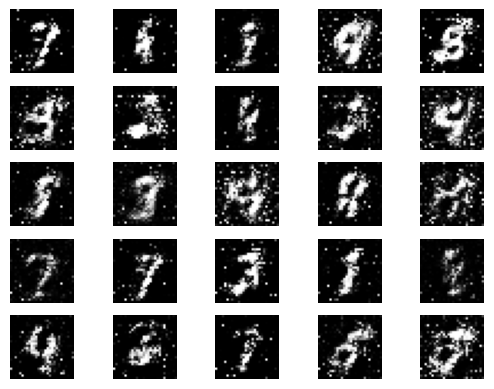

[201/400][0/16] 	Loss_D: 0.8534	Loss_G: 2.7229	D(x): 0.9414	D(G(z)): 0.4811
[202/400][0/16] 	Loss_D: 0.8607	Loss_G: 1.2349	D(x): 0.5907	D(G(z)): 0.0460
[203/400][0/16] 	Loss_D: 0.4722	Loss_G: 2.1740	D(x): 0.9104	D(G(z)): 0.2801
[204/400][0/16] 	Loss_D: 0.6098	Loss_G: 1.3401	D(x): 0.7011	D(G(z)): 0.0728
[205/400][0/16] 	Loss_D: 1.5878	Loss_G: 0.6064	D(x): 0.3683	D(G(z)): 0.0174
[206/400][0/16] 	Loss_D: 0.5860	Loss_G: 1.7833	D(x): 0.7575	D(G(z)): 0.1779
[207/400][0/16] 	Loss_D: 0.4980	Loss_G: 2.0138	D(x): 0.8060	D(G(z)): 0.1840
[208/400][0/16] 	Loss_D: 0.5257	Loss_G: 2.6155	D(x): 0.7905	D(G(z)): 0.1906
[209/400][0/16] 	Loss_D: 0.8267	Loss_G: 3.9174	D(x): 0.9563	D(G(z)): 0.4641
[210/400][0/16] 	Loss_D: 0.4372	Loss_G: 2.6405	D(x): 0.8767	D(G(z)): 0.2290
[211/400][0/16] 	Loss_D: 0.4749	Loss_G: 2.8402	D(x): 0.8644	D(G(z)): 0.2424
[212/400][0/16] 	Loss_D: 0.4703	Loss_G: 2.8615	D(x): 0.9179	D(G(z)): 0.2777
[213/400][0/16] 	Loss_D: 0.4785	Loss_G: 1.9965	D(x): 0.7403	D(G(z)): 0.1037
[214/400][0/

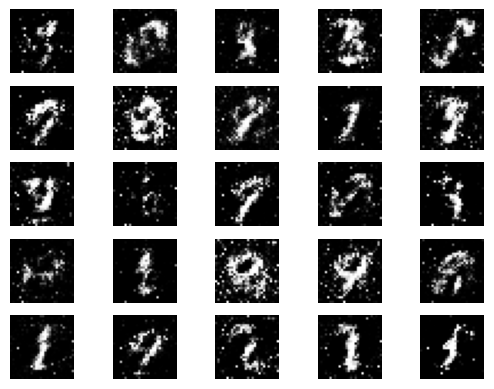

[226/400][0/16] 	Loss_D: 0.5206	Loss_G: 2.0823	D(x): 0.8928	D(G(z)): 0.2867
[227/400][0/16] 	Loss_D: 0.5291	Loss_G: 2.5964	D(x): 0.8565	D(G(z)): 0.2684
[228/400][0/16] 	Loss_D: 0.3290	Loss_G: 3.2105	D(x): 0.8973	D(G(z)): 0.1733
[229/400][0/16] 	Loss_D: 0.4673	Loss_G: 2.0462	D(x): 0.8288	D(G(z)): 0.1966
[230/400][0/16] 	Loss_D: 0.4593	Loss_G: 3.3610	D(x): 0.9235	D(G(z)): 0.2804
[231/400][0/16] 	Loss_D: 0.4664	Loss_G: 1.6903	D(x): 0.7767	D(G(z)): 0.1164
[232/400][0/16] 	Loss_D: 0.4377	Loss_G: 2.7480	D(x): 0.8420	D(G(z)): 0.1992
[233/400][0/16] 	Loss_D: 0.6859	Loss_G: 3.1934	D(x): 0.8937	D(G(z)): 0.3978
[234/400][0/16] 	Loss_D: 0.5055	Loss_G: 2.3380	D(x): 0.8559	D(G(z)): 0.2620
[235/400][0/16] 	Loss_D: 0.5971	Loss_G: 3.5080	D(x): 0.8857	D(G(z)): 0.3341
[236/400][0/16] 	Loss_D: 1.0580	Loss_G: 1.0791	D(x): 0.5204	D(G(z)): 0.0603
[237/400][0/16] 	Loss_D: 1.7809	Loss_G: 1.4284	D(x): 0.3870	D(G(z)): 0.0109
[238/400][0/16] 	Loss_D: 0.4442	Loss_G: 2.7556	D(x): 0.8622	D(G(z)): 0.2231
[239/400][0/

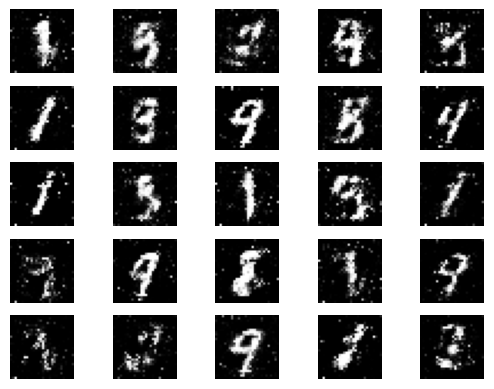

[251/400][0/16] 	Loss_D: 0.5884	Loss_G: 1.9996	D(x): 0.8152	D(G(z)): 0.2617
[252/400][0/16] 	Loss_D: 0.5823	Loss_G: 2.5951	D(x): 0.8813	D(G(z)): 0.3254
[253/400][0/16] 	Loss_D: 0.7562	Loss_G: 1.0943	D(x): 0.6483	D(G(z)): 0.1214
[254/400][0/16] 	Loss_D: 0.8358	Loss_G: 1.5563	D(x): 0.6130	D(G(z)): 0.0443
[255/400][0/16] 	Loss_D: 0.5442	Loss_G: 2.3465	D(x): 0.7542	D(G(z)): 0.1287
[256/400][0/16] 	Loss_D: 0.5977	Loss_G: 1.9576	D(x): 0.7177	D(G(z)): 0.0865
[257/400][0/16] 	Loss_D: 0.6135	Loss_G: 2.3151	D(x): 0.8438	D(G(z)): 0.2995
[258/400][0/16] 	Loss_D: 0.4653	Loss_G: 2.2156	D(x): 0.8486	D(G(z)): 0.2188
[259/400][0/16] 	Loss_D: 0.4370	Loss_G: 2.6797	D(x): 0.8573	D(G(z)): 0.2001
[260/400][0/16] 	Loss_D: 0.5249	Loss_G: 2.9375	D(x): 0.9181	D(G(z)): 0.3085
[261/400][0/16] 	Loss_D: 0.5778	Loss_G: 1.3770	D(x): 0.7679	D(G(z)): 0.1628
[262/400][0/16] 	Loss_D: 0.4715	Loss_G: 2.0832	D(x): 0.8148	D(G(z)): 0.1916
[263/400][0/16] 	Loss_D: 0.4028	Loss_G: 2.1338	D(x): 0.8449	D(G(z)): 0.1494
[264/400][0/

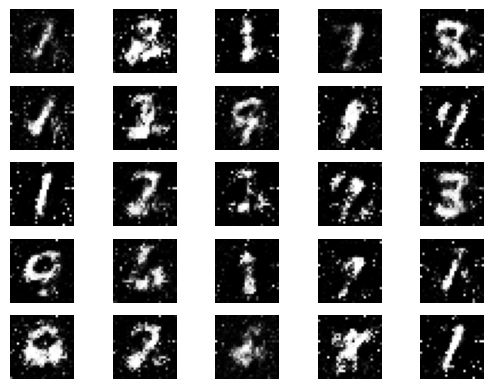

[276/400][0/16] 	Loss_D: 0.7375	Loss_G: 1.1855	D(x): 0.6385	D(G(z)): 0.0703
[277/400][0/16] 	Loss_D: 0.6598	Loss_G: 3.0997	D(x): 0.8818	D(G(z)): 0.3667
[278/400][0/16] 	Loss_D: 0.4166	Loss_G: 2.8629	D(x): 0.8571	D(G(z)): 0.1898
[279/400][0/16] 	Loss_D: 0.5337	Loss_G: 2.5113	D(x): 0.7948	D(G(z)): 0.1919
[280/400][0/16] 	Loss_D: 0.5901	Loss_G: 1.8978	D(x): 0.7970	D(G(z)): 0.2180
[281/400][0/16] 	Loss_D: 1.5421	Loss_G: 4.0094	D(x): 0.9717	D(G(z)): 0.7252
[282/400][0/16] 	Loss_D: 0.7342	Loss_G: 1.1484	D(x): 0.6262	D(G(z)): 0.1075
[283/400][0/16] 	Loss_D: 0.6217	Loss_G: 1.9630	D(x): 0.7999	D(G(z)): 0.2446
[284/400][0/16] 	Loss_D: 0.6986	Loss_G: 1.4249	D(x): 0.7219	D(G(z)): 0.2279
[285/400][0/16] 	Loss_D: 0.6223	Loss_G: 1.8750	D(x): 0.7941	D(G(z)): 0.2524
[286/400][0/16] 	Loss_D: 0.4757	Loss_G: 2.0530	D(x): 0.7723	D(G(z)): 0.1271
[287/400][0/16] 	Loss_D: 0.5671	Loss_G: 1.8270	D(x): 0.7448	D(G(z)): 0.1709
[288/400][0/16] 	Loss_D: 0.8907	Loss_G: 3.4161	D(x): 0.8704	D(G(z)): 0.4699
[289/400][0/

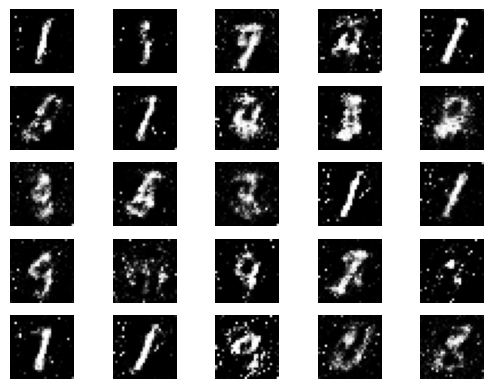

[301/400][0/16] 	Loss_D: 0.6845	Loss_G: 3.2877	D(x): 0.9153	D(G(z)): 0.4184
[302/400][0/16] 	Loss_D: 1.0981	Loss_G: 0.6356	D(x): 0.4667	D(G(z)): 0.0586
[303/400][0/16] 	Loss_D: 0.7683	Loss_G: 1.7183	D(x): 0.6407	D(G(z)): 0.0936
[304/400][0/16] 	Loss_D: 0.7108	Loss_G: 3.0091	D(x): 0.8879	D(G(z)): 0.3953
[305/400][0/16] 	Loss_D: 0.6146	Loss_G: 2.2655	D(x): 0.7892	D(G(z)): 0.2365
[306/400][0/16] 	Loss_D: 1.2012	Loss_G: 3.6235	D(x): 0.9459	D(G(z)): 0.6122
[307/400][0/16] 	Loss_D: 0.6410	Loss_G: 1.6146	D(x): 0.7245	D(G(z)): 0.1872
[308/400][0/16] 	Loss_D: 1.0237	Loss_G: 3.5799	D(x): 0.9362	D(G(z)): 0.5601
[309/400][0/16] 	Loss_D: 1.0145	Loss_G: 1.3206	D(x): 0.5261	D(G(z)): 0.0563
[310/400][0/16] 	Loss_D: 0.7440	Loss_G: 2.7989	D(x): 0.9082	D(G(z)): 0.4227
[311/400][0/16] 	Loss_D: 0.6966	Loss_G: 3.3005	D(x): 0.8731	D(G(z)): 0.3861
[312/400][0/16] 	Loss_D: 0.6299	Loss_G: 2.4194	D(x): 0.8650	D(G(z)): 0.3305
[313/400][0/16] 	Loss_D: 1.2773	Loss_G: 4.1538	D(x): 0.9506	D(G(z)): 0.6516
[314/400][0/

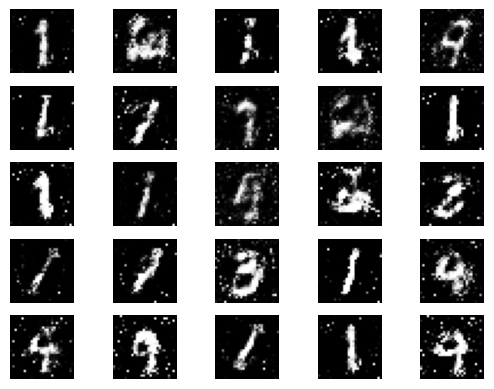

[326/400][0/16] 	Loss_D: 0.7133	Loss_G: 1.2803	D(x): 0.6625	D(G(z)): 0.1259
[327/400][0/16] 	Loss_D: 1.0724	Loss_G: 1.4340	D(x): 0.5404	D(G(z)): 0.0514
[328/400][0/16] 	Loss_D: 0.7060	Loss_G: 1.0296	D(x): 0.6952	D(G(z)): 0.1952
[329/400][0/16] 	Loss_D: 0.6219	Loss_G: 2.1209	D(x): 0.7974	D(G(z)): 0.2619
[330/400][0/16] 	Loss_D: 0.6319	Loss_G: 2.9434	D(x): 0.8629	D(G(z)): 0.3389
[331/400][0/16] 	Loss_D: 0.6195	Loss_G: 2.1936	D(x): 0.7886	D(G(z)): 0.2398
[332/400][0/16] 	Loss_D: 0.8524	Loss_G: 3.4569	D(x): 0.9404	D(G(z)): 0.5063
[333/400][0/16] 	Loss_D: 0.7471	Loss_G: 2.9978	D(x): 0.9053	D(G(z)): 0.4287
[334/400][0/16] 	Loss_D: 0.8444	Loss_G: 1.4034	D(x): 0.6211	D(G(z)): 0.0894
[335/400][0/16] 	Loss_D: 0.4777	Loss_G: 2.1786	D(x): 0.8476	D(G(z)): 0.2184
[336/400][0/16] 	Loss_D: 0.9346	Loss_G: 3.0196	D(x): 0.9300	D(G(z)): 0.5221
[337/400][0/16] 	Loss_D: 0.7411	Loss_G: 1.8576	D(x): 0.7299	D(G(z)): 0.2024
[338/400][0/16] 	Loss_D: 0.6468	Loss_G: 2.0444	D(x): 0.8265	D(G(z)): 0.3094
[339/400][0/

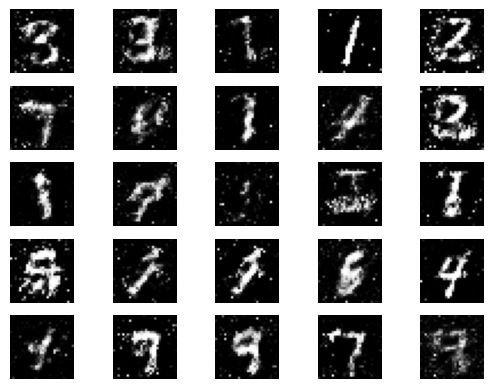

[351/400][0/16] 	Loss_D: 0.9527	Loss_G: 0.6116	D(x): 0.5272	D(G(z)): 0.0932
[352/400][0/16] 	Loss_D: 0.5645	Loss_G: 1.9781	D(x): 0.7382	D(G(z)): 0.1609
[353/400][0/16] 	Loss_D: 0.8769	Loss_G: 2.6398	D(x): 0.9003	D(G(z)): 0.4754
[354/400][0/16] 	Loss_D: 0.8405	Loss_G: 2.3369	D(x): 0.8324	D(G(z)): 0.4046
[355/400][0/16] 	Loss_D: 0.6541	Loss_G: 1.4124	D(x): 0.7700	D(G(z)): 0.2539
[356/400][0/16] 	Loss_D: 1.1099	Loss_G: 0.7460	D(x): 0.4654	D(G(z)): 0.0809
[357/400][0/16] 	Loss_D: 1.3998	Loss_G: 3.4760	D(x): 0.9375	D(G(z)): 0.6803
[358/400][0/16] 	Loss_D: 0.8051	Loss_G: 0.7392	D(x): 0.6241	D(G(z)): 0.1760
[359/400][0/16] 	Loss_D: 0.7353	Loss_G: 2.7443	D(x): 0.8822	D(G(z)): 0.3970
[360/400][0/16] 	Loss_D: 1.6803	Loss_G: 0.2907	D(x): 0.3321	D(G(z)): 0.0338
[361/400][0/16] 	Loss_D: 0.8590	Loss_G: 0.8279	D(x): 0.5363	D(G(z)): 0.0973
[362/400][0/16] 	Loss_D: 1.0298	Loss_G: 0.4530	D(x): 0.5006	D(G(z)): 0.1401
[363/400][0/16] 	Loss_D: 0.6592	Loss_G: 2.2445	D(x): 0.8372	D(G(z)): 0.3084
[364/400][0/

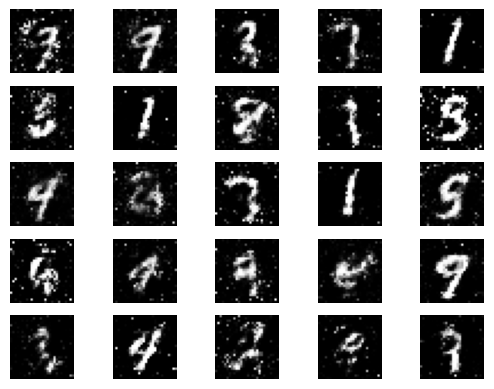

[376/400][0/16] 	Loss_D: 1.4103	Loss_G: 3.5070	D(x): 0.9538	D(G(z)): 0.6859
[377/400][0/16] 	Loss_D: 0.9961	Loss_G: 3.2692	D(x): 0.9407	D(G(z)): 0.5528
[378/400][0/16] 	Loss_D: 0.7279	Loss_G: 1.3290	D(x): 0.7254	D(G(z)): 0.2353
[379/400][0/16] 	Loss_D: 0.6248	Loss_G: 1.9758	D(x): 0.7860	D(G(z)): 0.2495
[380/400][0/16] 	Loss_D: 0.7176	Loss_G: 1.0942	D(x): 0.6227	D(G(z)): 0.1428
[381/400][0/16] 	Loss_D: 0.7717	Loss_G: 1.7970	D(x): 0.6467	D(G(z)): 0.1349
[382/400][0/16] 	Loss_D: 1.2215	Loss_G: 4.0656	D(x): 0.9261	D(G(z)): 0.5916
[383/400][0/16] 	Loss_D: 1.0440	Loss_G: 0.6801	D(x): 0.4823	D(G(z)): 0.0684
[384/400][0/16] 	Loss_D: 0.9338	Loss_G: 0.8684	D(x): 0.5595	D(G(z)): 0.1221
[385/400][0/16] 	Loss_D: 0.7123	Loss_G: 3.0155	D(x): 0.8898	D(G(z)): 0.4072
[386/400][0/16] 	Loss_D: 0.5806	Loss_G: 1.6540	D(x): 0.7523	D(G(z)): 0.1924
[387/400][0/16] 	Loss_D: 0.6300	Loss_G: 2.3914	D(x): 0.8407	D(G(z)): 0.3061
[388/400][0/16] 	Loss_D: 0.7290	Loss_G: 1.1976	D(x): 0.6705	D(G(z)): 0.1440
[389/400][0/

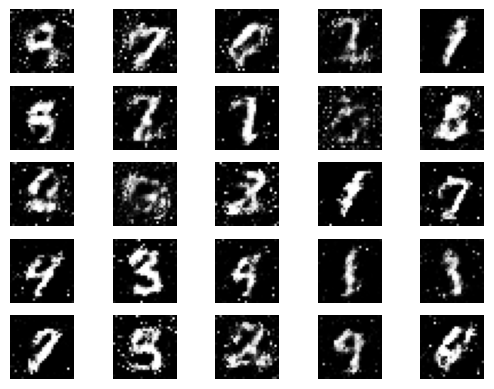

In [11]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

sample_interval=25

print("Starting Training")
# For each epoch
for epoch in range(n_epochs):
  # For each batch in the dataloader
  for i, data in enumerate(mnist_train_loader, 0):
    for iter_inner in range(0,n_iters_inner):
        
      ############################
      ### Train discriminator
      ############################
      ## Train with true data batch
      disc_model.zero_grad()
      # create true data and labels 
      true_imgs = data[0].to(device)
      true_labels = torch.ones((true_imgs.size(0), 1)).to(device)
      # put true data through discriminator
      d_output_true = disc_model(true_imgs)
      # bce loss on true data
      d_loss_true = bce_criterion(d_output_true, true_labels)
      # backpropagation for discriminator, true loss
      d_loss_true.backward()
      disc_true_value = d_output_true.mean().item()

      ## Train with fake data batch
      # create fake data and labels
      # generate batch of random latent vectors
      z_latent_noise = torch.tensor(np.random.normal(0, 1, (true_imgs.size(0), z_dim))).float().to(device)
      # Generate batch of fake images
      fake_imgs = gen_model(z_latent_noise)
      fake_labels = torch.zeros((true_imgs.size(0), 1)).to(device)
      # put fake data through discriminator
      disc_output_fake = disc_model(fake_imgs.detach())
      # bce loss on fake data
      disc_loss_fake = bce_criterion(disc_output_fake, fake_labels)
      # backpropagation for discriminator, fake loss
      disc_loss_fake.backward()
      disc_fake_value = disc_output_fake.mean().item()
      # Update discriminator
      optimizer_disc.step()

      d_loss_total = d_loss_true+disc_loss_fake

    ############################
    ### Train generator
    ############################
    gen_model.zero_grad()
    # We have updated the discriminator, so we need to update the output of the discriminator
    disc_gen_output_fake = disc_model(fake_imgs)
    # Generator loss, using the custom loss
    g_loss = loss_fn_gen(disc_gen_output_fake)
    # backpropagation for generator
    g_loss.backward()
    # Update generator
    optimizer_gen.step()

    # Output training stats
    if i % 200 == 0:
      print('[%d/%d][%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
      % (epoch, n_epochs, i, len(mnist_train_loader),d_loss_total.item(), g_loss.item(), disc_true_value, disc_fake_value ))

    # Save Losses for plotting later
    G_losses.append(g_loss.item())
    D_losses.append(d_loss_total.item())

  if(epoch % sample_interval == 0):
    sample_images(gen_model,z_dim, rand_seed=30)

# end samples
sample_images(gen_model,z_dim, rand_seed=30)


## 6/ Navigating in the latent space

One of the main interests in the latent space is to be able to __navigate__ in it. For instance, one operation which is very common is to take two points $z_0$ and $z_1$ and to interpolate between the two. The images resulting from the generation of the interpolated points should ideally be a mix between the two initial points. 

The simplest method of interpolation is simply linear interpolation along the line connecting the two points. Obviously, this supposes that the latent space is linear in some sense, which may not be true, but we are going to take this approach here. 

First, find two inital points $z_0$ and $z_1$ which you feel represent two different digits well, and display their resulting generated images.  

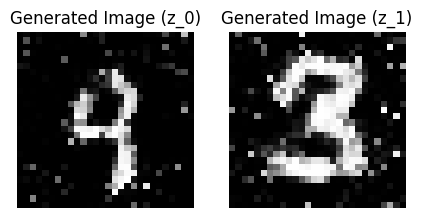

In [86]:
random_seed = 110
torch.manual_seed(random_seed)
z_0 = torch.tensor(np.random.normal(0, 1, (1, z_dim))).float().to(device)
x_0 = gen_model(z_0).squeeze().detach().cpu().numpy()

random_seed = 64
torch.manual_seed(random_seed)
z_1 = torch.tensor(np.random.normal(0, 1, (1, z_dim))).float().to(device)
x_1 = gen_model(z_1).squeeze().detach().cpu().numpy()

# Display images
fig, axes = plt.subplots(1, 2, figsize=(5, 5))
axes[0].imshow(x_0, cmap='gray')
axes[0].set_title('Generated Image (z_0)')
axes[0].axis('off')
axes[1].imshow(x_1, cmap='gray')
axes[1].set_title('Generated Image (z_1)')
axes[1].axis('off')
plt.show()


Now, carry out the interpolation between these two points. You should __include__ the starting and ending codes $z_0$ and $z_1$. Display the results.

In [91]:
n_interpolation = 20

# Linear interpolation
interpolations = torch.linspace(0, 1, n_interpolation).view(-1, 1).to(device)
interpolation_codes = z_0 * (1 - interpolations) + z_1 * interpolations

# Generate interpolated images
interpolation_images = gen_model(interpolation_codes).detach().cpu().numpy()

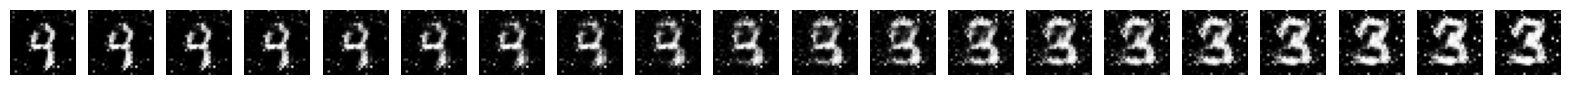

In [92]:
fig, axs = plt.subplots(1, n_interpolation, figsize=(20, 20))
for i in range(n_interpolation):
    axs[i].imshow(interpolation_images[i].squeeze(), cmap='gray')
    axs[i].axis('off')
plt.show()


What do you think of the quality of the output images ?

__Answer__

The results are not excellent, but they are relatively good, since we implemented a simple GAN, and with a relativaly shallow architecture. We could try to improve the results by using a deeper architecture, or by using the Wasserstein GAN loss function. In addition, the variation of the results is high, sometimes it is very clear, but sometimes it is difficult to distinguish the digits. 

## 7/ Evaluation of navigation

Now, we are going to evaluate this navigation. We will investigate two properties:

- 1/ We are going to see whether by navigating between two points, the model produces images which are categorised in either of the classes (beginning class or end class), or if it traverses a region which is categorised in another class;
- 2/ We are going to see whether the confidence of a classification network in different regions varies much. In other words, when we navigate in the latent space, do we go into zones which do not correspond to any number (according to the classification network) ? 

For this, we will first need a classification network. Take the code from the last lab work on variational autoencoders, and extract the section where we trained a classifier on mnist. Here is the architecture we used:

- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- MaxPool2D, stride=(2,2)
- Flatten
- Dense layer

In [20]:
learning_rate = 0.01
n_epochs = 20
batch_size = 64
nb_classes = int(mnist_trainset.targets.max()+1)

# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)

# --- Size of the successive layers
n_h_0 = 1 #greyscale input images
n_h_1 = nb_filters
n_h_2 = nb_filters

mnist_classification_model = nn.Sequential(
    nn.Conv2d(n_h_0, n_h_1, kernel_size, stride=1, padding='same'),
    nn.ReLU(),
    nn.Conv2d(n_h_1, n_h_2, kernel_size, stride=1, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(pool_size, stride=2),
    nn.Flatten(),
    nn.Linear(n_h_2*14*14, nb_classes)
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_classification_model.parameters(), lr=learning_rate)


In [21]:
def get_accuracy(x_pred,x_label):
  acc = torch.sum(x_pred == x_label)/(x_pred.shape[0])
  return acc

In [22]:
train_losses=[]
valid_losses=[]

for epoch in range(0,n_epochs):
  train_loss=0.0

  for batch_idx, (imgs, labels) in enumerate(mnist_train_loader):
    #print (imgs.shape)
    # set the gradients back to 0
    optimizer.zero_grad()
    predict=mnist_classification_model(imgs)
    # apply loss function
    loss=criterion(predict,labels)
    acc = get_accuracy(torch.argmax(predict,dim=1),labels)
    # backpropagation
    loss.backward()
    optimizer.step()
    train_loss=loss.item()
  print('Epoch:{} Train Loss:{:.4f} Accuracy:{:.4f}'.format(epoch,train_loss/imgs.shape[0],acc))

Epoch:0 Train Loss:0.0080 Accuracy:0.9500
Epoch:1 Train Loss:0.0018 Accuracy:0.9750
Epoch:2 Train Loss:0.0011 Accuracy:0.9750
Epoch:3 Train Loss:0.0003 Accuracy:1.0000
Epoch:4 Train Loss:0.0005 Accuracy:1.0000
Epoch:5 Train Loss:0.0000 Accuracy:1.0000
Epoch:6 Train Loss:0.0001 Accuracy:1.0000
Epoch:7 Train Loss:0.0000 Accuracy:1.0000
Epoch:8 Train Loss:0.0000 Accuracy:1.0000
Epoch:9 Train Loss:0.0000 Accuracy:1.0000
Epoch:10 Train Loss:0.0000 Accuracy:1.0000
Epoch:11 Train Loss:0.0000 Accuracy:1.0000
Epoch:12 Train Loss:0.0000 Accuracy:1.0000
Epoch:13 Train Loss:0.0000 Accuracy:1.0000
Epoch:14 Train Loss:0.0000 Accuracy:1.0000
Epoch:15 Train Loss:0.0000 Accuracy:1.0000
Epoch:16 Train Loss:0.0000 Accuracy:1.0000
Epoch:17 Train Loss:0.0000 Accuracy:1.0000
Epoch:18 Train Loss:0.0000 Accuracy:1.0000
Epoch:19 Train Loss:0.0000 Accuracy:1.0000


### 7.1/ Evaluation of navigation part 1

Now, create a function which returns the classification returned by this network on mnist images. Remember, the classification model above returns the values __before__ the softmax is applied, and here we want the argmax, rather than the maximum probability. __Note__: the torch.max function returns a tuple: (max_values, max_indices).


In [23]:
def predict_mnist_class(imgs_in,classification_model):
  output_classes = torch.argmax(classification_model(imgs_in),dim=1)
  return(output_classes)

Carry out and print the classification of your interpolated latent space images. What are your remarks ? Does the latent space navigation traverse regions with classes other than those of $z_0$ and $z_1$ ?

In [97]:
z_classes = predict_mnist_class(torch.tensor(interpolation_images),mnist_classification_model)
print(z_classes)

tensor([9, 9, 4, 4, 4, 4, 4, 4, 4, 4, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3])


__Answer__

The latent space navigation does traverse regions with classes other than those of $z_0$ and $z_1$, although it depends very much on the digit generated, which is not always very clear or stable. Nonetheless, we can see that the CNN classifies the digits as different classes in the middle of the vector.

### 7.2/ Evaluation of navigation part 2

Even though the network may predict coherent image classes during the navigation, it may predict these classes with different confidences. Ideally, we would like the latent space to contain codes which produce images of constant quality. Therefore, as mentioned above, we want to check these prediction confidences during navigation on our GAN.

Carry this out now. First of all, define a function which, instead of funding the output *classes* of the interpolations, find the *probability* of the most likely class (the same operation as in the lab on variational autoencoders).


In [51]:
def predict_mnist_confidence(imgs_in,classification_model):
  output_classes = torch.max(classification_model(imgs_in),dim=1)
  return(output_classes)

In [98]:
soft = nn.Softmax(dim=1)
z_confidence = (soft(mnist_classification_model(torch.tensor(interpolation_images)))).max(dim=1)
print(z_confidence)

torch.return_types.max(
values=tensor([0.8651, 0.7093, 0.5669, 0.8002, 0.9229, 0.9622, 0.9803, 0.9828, 0.9741,
        0.8588, 0.6842, 0.5197, 0.7041, 0.8323, 0.9207, 0.9422, 0.9563, 0.9624,
        0.9521, 0.9441], grad_fn=<MaxBackward0>),
indices=tensor([9, 9, 4, 4, 4, 4, 4, 4, 4, 4, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3]))


Using this function, carry out the second evaluation on the images generated by interpolated latent codes.

Does the confidence change greatly during interpolation ? Does the navigation go through zones where the classification is not confident ? Why do you think this is ? (think about the form/shape of the latent space).

__Answer__

Normally, the confidence greatly decreases as we go through the latent space, specially in the middle of the vector, which is the most "confused" region. That is, the images in the middle are not clear, so it is difficult to be sure. In addition, some images in the middle may have a high confidence, but be classified as a different digit, which is not ideal.

# __Optional__ : Training on CIFAR

If you want to try another, more challenging database, use the above code and modify it to carry out the GAN training on the CIFAR10 database. Note, it can take a long time to get good results

First, we download the data.

In [33]:
# convert input to Pytorch tensors
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

# extract mnist data
cifar_trainset = datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
print(cifar_trainset)

#create data loader with smaller dataset size
max_cifar_size = 2000
cifar_trainset_reduced = torch.utils.data.random_split(cifar_trainset, [max_cifar_size, len(cifar_trainset)-max_cifar_size])[0] 
cifar_train_loader = torch.utils.data.DataLoader(cifar_trainset_reduced, batch_size=64, shuffle=True)

# download test dataset
cifar_testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
cifar_test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=64, shuffle=True)

n_rows = 32
n_cols = 32
n_channels = 3
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)

100%|██████████| 170498071/170498071 [01:13<00:00, 2323724.28it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Files already downloaded and verified


Now, we can redefine the hyper-parameters of the model (change if you wish)

In [34]:
## GAN parameters
z_dim = 10
batch_size = 64
n_epochs = 300
## parameters for training
n_iters_inner=1	#number of internal loops
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5

For this case of CIFAR, implement the following architecture :

- Generator :
  - Dense layer to size 1024
  - Leaky ReLU ($\alpha=0.2$)
  - Reshape, to size $4 \times 4 \times64$
  - % size = $4\times4\times64$
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $8\times 8\times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size=$16 \times 16 \times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=3,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $32 \times 32 \times 3$
  - Tanh activation ( you can use ```Activation('tanh')```)

- Discriminator :
  - % input size : $32 \times 32 \times 3$
  - Conv2D, 32 filters, kernel size = (3,3), strides = (1,1),padding = same
  - % size $32 \times 32 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - %size : $16 \times 16 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 64 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $8 \times 8 \times 64$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $4 \times 4 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Flatten
  - Dense layer to size 1
  - Sigmoid activation

  Implement this architecture below, and train the GAN. 

In [ ]:
# GAN implementation

# FILL IN HERE

Now, carry out the training (use code above)

In [ ]:
# training code

# FILL IN HERE